<a href="https://colab.research.google.com/github/konstantin1998/first-repository/blob/master/litpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchsummary

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import PIL
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
class DataGenerator():
  def __init__(self, train_dir, test_dir, results_file):
    self.train_dir = train_dir
    self.test_dir = test_dir
    results_df = pd.read_csv(results_file)
    self.results = pd.Series(results_df['score'].values, index=results_df['name'].values)
  
  def get_quality(self, img_path):
    dir, name = os.path.split(img_path)
    quality = self.results[name]
    return quality

  def load_sample(self, path):
    try:
      img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      img = img.reshape((1, *img.shape)).astype('float32')
      tensor = torch.from_numpy(img)
      return tensor
    except AttributeError:
      print('exception in load_sample:', path)
  
  def shuffle(self, arr):
    part1, part2 = train_test_split(arr, train_size=0.5, random_state=42)
    part1.extend(part2)
    return part1

  def assign_qualities(self, dataset):
    items = []
    for sample in dataset.samples:
      path, label = sample
      quality = self.get_quality(path)
      sample = (path, float(quality))
      items.append(sample)
           
    items = self.shuffle(items)
    dataset.samples = items

  def prepare_data(self):
    trainset = torchvision.datasets.ImageFolder(
      root=self.train_dir,
      loader=self.load_sample
    )
    self.assign_qualities(trainset)
    trainloader = torch.utils.data.DataLoader(
      trainset,
      batch_size=100,
      shuffle=False,
      num_workers=4
    )
    print(len(trainset.samples))
    testset = torchvision.datasets.ImageFolder(
      root=self.test_dir,
      loader=self.load_sample
    )
    print(len(testset.samples))
    self.assign_qualities(testset)
    testloader = torch.utils.data.DataLoader(
      testset,
      batch_size=40,
      shuffle=False, 
      num_workers=2
    )

    return trainloader, testloader


In [ ]:
data_generator = DataGenerator('X-radar_cropped/train',
                               'X-radar_cropped/test',
                               'X-radar_cropped/data_for_learning_manual_markdown.csv')
trainloader, testloader = data_generator.prepare_data()


1950
487


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 4),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(2)  
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, dilation=3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )    
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, 4),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2)       
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, dilation=3),
        nn.BatchNorm2d(64),
        nn.ReLU()         
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(64, 160, 4),
        nn.BatchNorm2d(160),
        nn.ReLU()       
    )
    self.conv6 = nn.Sequential(
        nn.Conv2d(in_channels=160, out_channels=128, kernel_size=4, dilation=3),
        nn.BatchNorm2d(128),
        nn.ReLU() 
    )
    self.conv7 = nn.Sequential(
        nn.Conv2d(128, 64, 4),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.conv8 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, dilation=3),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    self.conv9 = nn.Sequential(
        nn.Conv2d(32, 16, 4),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )
    self.conv10 = nn.Sequential(
        nn.Conv2d(16, 8, 4),
        nn.BatchNorm2d(8),
        nn.ReLU()
    )
    self.conv11 = nn.Sequential(
        nn.Conv2d(8, 4, 4),
        nn.BatchNorm2d(4),
        nn.ReLU()
    )
    self.fc = nn.Linear(4 * 27 * 85, 1)
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.conv8(x)
    x = self.conv9(x)
    x = self.conv10(x)
    x = self.conv11(x)

    x = x.view(x.size(0), -1)   
    x = self.fc(x)
    return x

In [ ]:
scaler = torch.cuda.amp.GradScaler()

def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    train_loss = 0
    
    model.train()
    for data, label in dataloader:
        
        data, label = data.to(device), label.to(device)
        label = label.float()
        with torch.cuda.amp.autocast():
          optim.zero_grad()
          output = model(data)
          output = output.reshape((output.shape[0]))     
          loss = criterion(output, label)
          
        loss = loss.float()  
        scaler.scale(loss).backward()
        
        
        scaler.step(optim)
        scaler.update()

        train_loss += loss.item()
        total += output.shape[0]
        
    return train_loss / total

In [ ]:
def test(model, criterion, dataloader, epoch, device):
    total = 0
    test_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            output = output.reshape((output.shape[0])).float()
            label = label.float()       
            loss = criterion(output, label)
            test_loss += loss
            total += data.shape[0]
    
    return test_loss / total

In [ ]:
"""
torch.manual_seed(10)
model = Model()
"""
model = torch.load('cropped534x1000/models/models/ckpt_11conv.pth')
torchsummary.summary(model.cuda(), (1, 534, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 531, 997]             136
       BatchNorm2d-2          [-1, 8, 531, 997]              16
              ReLU-3          [-1, 8, 531, 997]               0
         MaxPool2d-4          [-1, 8, 265, 498]               0
            Conv2d-5         [-1, 16, 259, 492]           1,168
       BatchNorm2d-6         [-1, 16, 259, 492]              32
              ReLU-7         [-1, 16, 259, 492]               0
         MaxPool2d-8         [-1, 16, 129, 246]               0
            Conv2d-9         [-1, 32, 126, 243]           8,224
      BatchNorm2d-10         [-1, 32, 126, 243]              64
             ReLU-11         [-1, 32, 126, 243]               0
        MaxPool2d-12          [-1, 32, 63, 121]               0
           Conv2d-13          [-1, 64, 57, 115]          18,496
      BatchNorm2d-14          [-1, 64, 

In [ ]:
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.conv2.parameters():
    param.requires_grad = False
for param in model.conv3.parameters():
    param.requires_grad = False
for param in model.conv4.parameters():
    param.requires_grad = False
for param in model.conv5.parameters():
    param.requires_grad = False


torchsummary.summary(model.cuda(), (1, 534, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 531, 997]             136
       BatchNorm2d-2          [-1, 8, 531, 997]              16
              ReLU-3          [-1, 8, 531, 997]               0
         MaxPool2d-4          [-1, 8, 265, 498]               0
            Conv2d-5         [-1, 16, 259, 492]           1,168
       BatchNorm2d-6         [-1, 16, 259, 492]              32
              ReLU-7         [-1, 16, 259, 492]               0
         MaxPool2d-8         [-1, 16, 129, 246]               0
            Conv2d-9         [-1, 32, 126, 243]           8,224
      BatchNorm2d-10         [-1, 32, 126, 243]              64
             ReLU-11         [-1, 32, 126, 243]               0
        MaxPool2d-12          [-1, 32, 63, 121]               0
           Conv2d-13          [-1, 64, 57, 115]          18,496
      BatchNorm2d-14          [-1, 64, 

In [ ]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

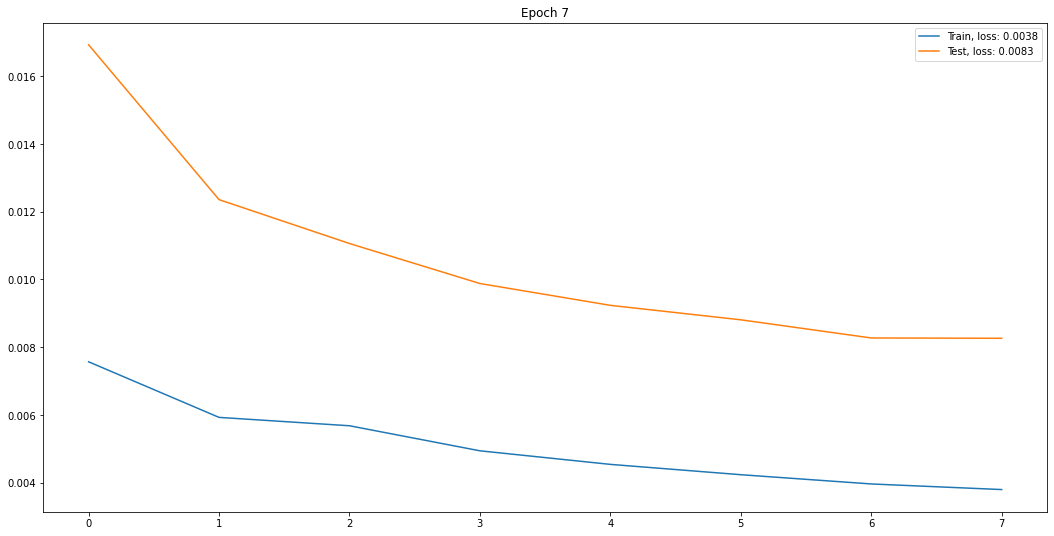

test losses: [tensor(0.0169, device='cuda:0'), tensor(0.0124, device='cuda:0'), tensor(0.0111, device='cuda:0'), tensor(0.0099, device='cuda:0'), tensor(0.0092, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(0.0083, device='cuda:0'), tensor(0.0083, device='cuda:0')]


In [ ]:
train_losses = []
test_losses = []

best_loss = 0.017
num_epochs = 8
for i in range(num_epochs):
    
    train_loss = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss = test(model, criterion, testloader, i, device)
    scheduler.step(test_loss) 
    test_losses.append(test_loss)
      
    if test_loss < best_loss:
        print('Saving...')
        best_loss = test_loss
        model_info = {
            'model': model,
            'loss': best_loss
        }
        torch.save(model_info, 'X-radar_cropped/models/ckpt_manual_markdown_transfer_learning.pth')
    
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

print('test losses:', test_losses)
    

In [ ]:
model_manual = torch.load('X-radar_cropped/models/ckpt_manual_markdown_transfer_learning.pth')['model']
model_auto = torch.load('X-radar_cropped/models/ckpt_augmentation_transfer_learning.pth')['model']

In [ ]:
from demonstration.results import results

img_dir = 'demonstration/crops'
names = []
tfms = []
entropies = []
brisques = []
excesses = []
model_autos = []
model_manuals = []

for res in results:
    name = res['name'][1]
    
    img_path = os.path.join(img_dir, name) 
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape((1, 1, *img.shape))
    tensor = torch.tensor(img, dtype=torch.float32)
    tensor = tensor.to(device)
    with torch.no_grad():
        output_manual = model_manual(tensor)
        output_auto = model_auto(tensor)
    output_manual = output_manual.to('cpu').numpy()[0][0]
    output_auto = output_auto.to('cpu').numpy()[0][0]
    
    names.append(name)
    tfms.append(res['tfm'])
    entropies.append(res['entropy'])
    brisques.append(res['brisque'])
    excesses.append(res['excess'])
    model_autos.append(output_auto)
    model_manuals.append(output_manual)

In [ ]:
data = pd.DataFrame({'name': names,
                    'tfm': tfms,
                    'entropy':entropies,
                    'brisque':brisques,
                    'excess': excesses,
                    'model_auto': model_autos,
                    'model_manual': model_manuals})
print(data)

                                                 name        tfm   entropy  \
0   19.08.2019_17.22.40_2nd_iter_Part_5_V0=46.00_E...  63.653354  4.286743   
1   19.08.2019_17.22.40_2nd_iter_Part_5_V0=47.00_E...  61.904291  4.274304   
2   19.08.2019_17.22.40_2nd_iter_Part_5_V0=48.00_E...  60.777632  4.260724   
3   19.08.2019_17.22.40_2nd_iter_Part_5_V0=49.00_E...  57.731771  4.250888   
4   19.08.2019_17.22.40_2nd_iter_Part_5_V0=50.00_E...  56.661461  4.240952   
5   19.08.2019_17.22.40_2nd_iter_Part_5_V0=51.00_E...  55.265230  4.229640   
6   19.08.2019_17.22.40_2nd_iter_Part_5_V0=53.00_E...  54.896908  4.210611   
7   19.08.2019_17.22.40_2nd_iter_Part_5_V0=54.00_E...  50.531273  4.198884   
8   19.08.2019_17.22.40_2nd_iter_Part_5_V0=55.00_E...  50.649453  4.191138   
9   19.08.2019_17.22.40_2nd_iter_Part_5_V0=56.00_E...  49.882169  4.179894   
10  19.08.2019_17.22.40_2nd_iter_Part_5_V0=58.00_E...  46.863890  4.160683   
11  19.08.2019_17.22.40_2nd_iter_Part_5_V0=59.00_E...  46.153145

In [ ]:
data.to_csv('demonstration/demonstration.csv')


In [ ]:
def normalize(series, eps = 0.001):
    series = series - min(series.values) + eps
    series = series / (max(series.values) + eps)
    return series

for column in ['model_manual', 'model_auto', 'tfm', 'brisque', 'excess', 'entropy']:
    data[column] = normalize(data[column])
data.to_csv('demonstration/demonstration_norm.csv')

In [ ]:
data = pd.read_csv('demonstration/demonstration_norm.csv')
print(data)

    Unnamed: 0                                               name       tfm  \
0            0  19.08.2019_17.22.40_2nd_iter_Part_5_V0=46.00_E...  0.999954   
1            1  19.08.2019_17.22.40_2nd_iter_Part_5_V0=47.00_E...  0.920001   
2            2  19.08.2019_17.22.40_2nd_iter_Part_5_V0=48.00_E...  0.868500   
3            3  19.08.2019_17.22.40_2nd_iter_Part_5_V0=49.00_E...  0.729267   
4            4  19.08.2019_17.22.40_2nd_iter_Part_5_V0=50.00_E...  0.680341   
5            5  19.08.2019_17.22.40_2nd_iter_Part_5_V0=51.00_E...  0.616517   
6            6  19.08.2019_17.22.40_2nd_iter_Part_5_V0=53.00_E...  0.599680   
7            7  19.08.2019_17.22.40_2nd_iter_Part_5_V0=54.00_E...  0.400119   
8            8  19.08.2019_17.22.40_2nd_iter_Part_5_V0=55.00_E...  0.405521   
9            9  19.08.2019_17.22.40_2nd_iter_Part_5_V0=56.00_E...  0.370447   
10          10  19.08.2019_17.22.40_2nd_iter_Part_5_V0=58.00_E...  0.232476   
11          11  19.08.2019_17.22.40_2nd_iter_Part_5_

In [ ]:
average = (data['entropy'] + data['excess'] + data['brisque'] + data['tfm']) / 4.0

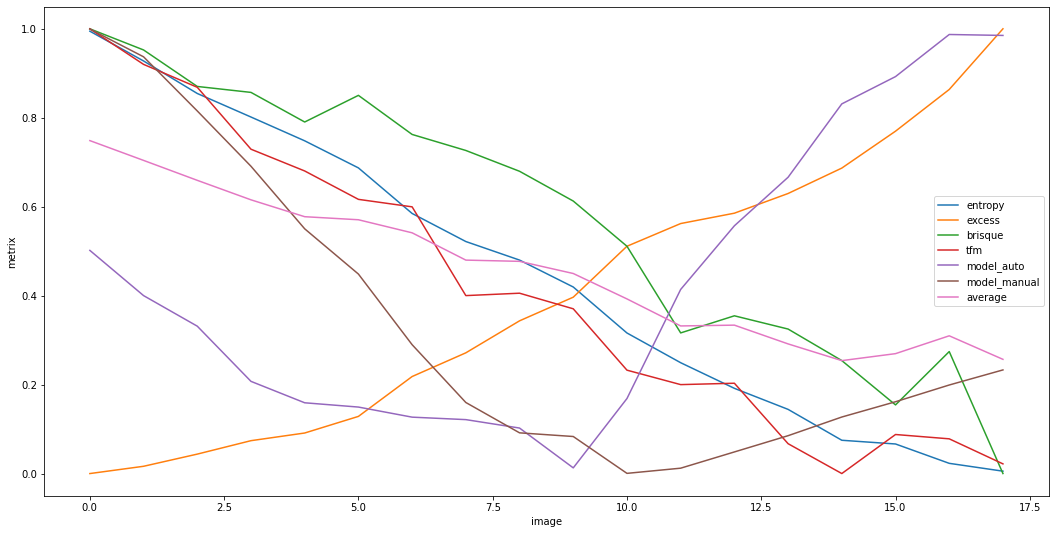

In [ ]:
num_points = len(data)
plt.figure(figsize=(18, 9))
plt.plot(np.arange(num_points), data['entropy'].values, label=f'entropy')
plt.plot(np.arange(num_points), data['excess'].values, label=f'excess')
plt.plot(np.arange(num_points), data['brisque'].values, label=f'brisque')
plt.plot(np.arange(num_points), data['tfm'].values, label=f'tfm')
plt.plot(np.arange(num_points), data['model_auto'].values, label=f'model_auto')
plt.plot(np.arange(num_points), data['model_manual'].values, label=f'model_manual')
plt.plot(np.arange(num_points), average.values, label=f'average')
plt.legend(loc='best')
plt.xlabel('image')
plt.ylabel('metrix')
plt.savefig('metrices.png')
plt.show()